In [6]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import os
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from google.colab import drive
drive.mount('/content/drive')

In [7]:
import os
drive_path = "test"

if os.path.exists(drive_path):
    files = os.listdir(drive_path)
    print(f"Files in {drive_path}:")
    for file in files:
        print(file)
else:
    print(f"The directory {drive_path} does not exist.")

Files in test:
leaf_blast
Rice Hispa
Neck_Blast
.DS_Store
Sheath Blight
healthy
bacterial_leaf_blight
brown_spot
leaf_scald
Tungro
narrow_brown_spot


In [30]:
model=models.resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model

/Users/giradasaiteja/env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/giradasaiteja/env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define transformations for testing data
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torch

train_dir = 'test'

full_dataset = ImageFolder(root=train_dir, transform=train_transforms)
print(f"Total images in the dataset: {len(full_dataset)}")

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
print(f"Splitting into {train_size} training samples and {val_size} validation samples.")


train_subset, val_subset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(
    train_subset,
    batch_size=32,
    shuffle=True,
    num_workers=8, 
    pin_memory=True
)

val_loader = DataLoader(
    val_subset,
    batch_size=32,
    shuffle=False,
    num_workers=8, 
    pin_memory=True
)

print("DataLoaders for training and validation have been created successfully.")

In [11]:
criterian=nn.CrossEntropyLoss()

In [12]:
import torch.optim as optim
loss_fn=nn.CrossEntropyLoss()
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:

def train(model,train_loader,loss_fn,optimizer):
    model.train()

    running_loss=0.0
    correc_predict=0
    total_samp=0
    for inputs,labels in train_loader:
        inputs,labels=inputs.to(device),labels.to(device)
        optimizer.zero_grad()
        outputs=model(inputs)
        loss=loss_fn(outputs,labels)
        loss.backward()
        optimizer.step() # Use xm.optimizer_step for TPU # Add mark_step for TPU


        running_loss+=loss.item()*inputs.size(0)
        _,predicted=torch.max(outputs.data,1)
        total_samp+=labels.size(0)
        correc_predict+=(predicted==labels).sum().item()
    epoch_loss=running_loss/total_samp
    epoch_acc=100*correc_predict/total_samp

    return epoch_loss,epoch_acc

def evaluate(model,val_loader,loss_fn):
    model.eval()

    running_loss=0.0
    correc_predict=0
    total_samp=0
    with torch.no_grad():
        for inputs,labels in val_loader:
            inputs,labels=inputs.to(device),labels.to(device)

            outputs=model(inputs)
            loss=loss_fn(outputs,labels)

            running_loss+=loss.item()*inputs.size(0)
        _,predicted=torch.max(outputs.data,1)
        total_samp+=labels.size(0)
        correc_predict+=(predicted==labels).sum().item()
    epoch_loss=running_loss/total_samp
    epoch_acc=100*correc_predict/total_samp

    return epoch_loss,epoch_acc

**Reasoning**:
I will execute the training loop for a specified number of epochs and evaluate the model periodically. Since the previous steps for setting up the training loop and evaluation are complete, I can combine these into a single block to train and evaluate the model for a few epochs. I will set the number of epochs to 12 and evaluate after each epoch to monitor the training progress.



In [14]:
eproaches=12
model.to(device)
for epoch in range(eproaches):
    train_loss,train_acc=train(model,train_loader,loss_fn,optimizer)
    eval_loss,eval_acc=evaluate(model,val_loader,loss_fn)

    print(f"epoch{epoch+1}:"
          f"train_loss:{train_loss:.2f},train_acc{train_acc:.4f}:"
          f"eval_loss:{eval_loss:.2f},eval_acc{eval_acc:.4f}:")
print("training finished")

epoch1:train_loss:0.56,train_acc82.3810:eval_loss:7.40,eval_acc86.3636:
epoch2:train_loss:0.23,train_acc91.6667:eval_loss:4.57,eval_acc90.9091:
epoch3:train_loss:0.17,train_acc93.9286:eval_loss:5.41,eval_acc95.4545:
epoch4:train_loss:0.19,train_acc93.2540:eval_loss:4.55,eval_acc95.4545:
epoch5:train_loss:0.13,train_acc95.7143:eval_loss:3.75,eval_acc100.0000:
epoch6:train_loss:0.13,train_acc95.2381:eval_loss:3.83,eval_acc100.0000:
epoch7:train_loss:0.13,train_acc95.8730:eval_loss:4.81,eval_acc90.9091:
epoch8:train_loss:0.12,train_acc96.4286:eval_loss:3.56,eval_acc95.4545:
epoch9:train_loss:0.11,train_acc96.1905:eval_loss:4.26,eval_acc95.4545:
epoch10:train_loss:0.09,train_acc97.2619:eval_loss:2.94,eval_acc86.3636:
epoch11:train_loss:0.10,train_acc96.7460:eval_loss:3.63,eval_acc100.0000:
epoch12:train_loss:0.09,train_acc96.7857:eval_loss:2.71,eval_acc95.4545:
training finished


In [15]:
MODEL_SAVE_PATH = 'rice_leaf.pth'

torch.save(model.state_dict(), MODEL_SAVE_PATH)

print(f"Model saved to {MODEL_SAVE_PATH}")

Model saved to rice_leaf.pth


In [25]:
! python3 predict_custom.py tungro948.jpg

Setting up your custom model and environment...
Using device: mps
predict_custom.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_

In [27]:
! python3 predict_custom.py brown_spot298.jpg

Setting up your custom model and environment...
Using device: mps
predict_custom.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_

In [17]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

model.eval()

all_preds = []
all_labels = []

# No need to calculate gradients for this part
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Finished collecting predictions.")

Finished collecting predictions.


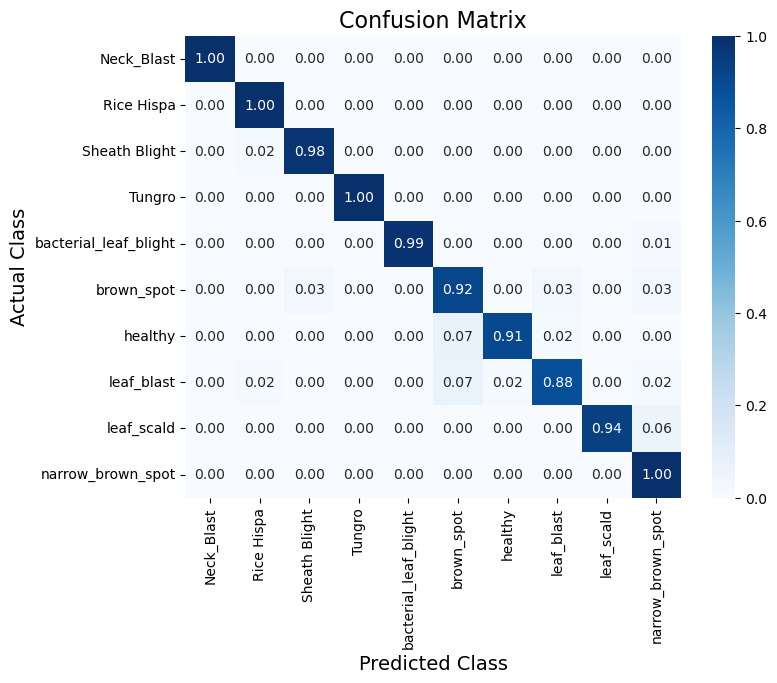

In [28]:
class_names = full_dataset.classes
cm = confusion_matrix(all_labels, all_preds)

# Optional: Normalize the matrix to show percentages instead of counts
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 2. Create the plot
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_normalized,
    annot=True,          # Show the numbers in the cells
    fmt='.2f',           # Format numbers to two decimal places
    cmap='Blues',        # Color scheme
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel('Predicted Class', fontsize=14)
plt.ylabel('Actual Class', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

In [ ]:
! cd ..